In [4]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.special import rel_entr
from math import log2
import sys

In [6]:
def get_kldiv(filename):
    
    ## extract data
    def hist_extract(filename, time):
        with open(filename) as f:
            lines = f.read().splitlines()
            edge_weight_array = []
            time_array = []
        #add noise to windows, no empty bins when normalize, no 0's (called regulariztion)
            for line in lines:
                edge_weight_pat = "tw: Edge From Node (\d{3}) to Node (\d{3}) ; Edge Speed : 0.5000000000000000000000 ; Edge Weight: ([\d\.-]+) ; Current Time: ([\d\.]+)"
                matches = re.search(edge_weight_pat, line)
                if matches:
                    #matches in order of info is extracted
                    match_list1 = (float(matches.group(3)))
                    match_list2 = (float(matches.group(4)))

                    #adds elements from .out file to the empty list
                    edge_weight_array.append(match_list1)
                    time_array.append(match_list2)

            #turn to array
            ta = np.asarray(time_array)
            edw = np.asarray(edge_weight_array)
            # return everything above here into an array 
            #belw is secobd fuction, takes in the array data and the time you want to analyze


            yn = pd.Series(edw[ta==0.0]) #need to find a way to get the ta equal to the first index of the time array
            yn1 = pd.Series(edw[ta== time])#change this to get next timepoint
            dat = yn1 - yn

            yn.reset_index(inplace=True, drop=True)
            yn1.reset_index(inplace=True, drop=True)

            ta_trunc = np.trunc(ta*10**2)/(10**2)
            x,bins,p = plt.hist(dat, density = False, range = (dat.min(), dat.max()), bins = 50) #numpy hist instead!

            #add 1 to the data to take care of the 0's
            for i in x:
                i = i+1
            #no need to plot histogram anymore, just need the normalized histogram values
            norm = x/x.max()

            # x is the histogram heights 
            return norm, x, ta_trunc
   ## get time points 
    def get_times(filename):
        with open(filename) as f:
            lines = f.read().splitlines()
            time_array = []

        for line in lines:
                edge_weight_pat = "Current Time: ([\d\.]+)"
                matches = re.search(edge_weight_pat, line)
                if matches:
                    #matches in order of info is extracted
                    match_list2 = (float(matches.group(1)))
                    #adds elements from .out file to the empty list
                    time_array.append(match_list2)

        #turn to array
        times = np.asarray(time_array)

        #get list with the value of each time point
        time_points = []

        #[ 0 1 2 3]
        for i in range(0,len(times)-1):
            if times[i] != times[i+1]:
                time_points.append(times[i])

        # couldnt figure out error so worked around it with this line  
        time_points.append(times[len(times)-1])


        return times, time_points
    
    times, time_points = get_times("0.out")
    
    
    ## get norms 
    def get_norms(filename, time_points):
        norms = []
        for i in time_points:
            norm, x, ta_trunc = hist_extract("0.out", i)
            norms.append(norm)
        return norms

    norms = get_norms("0.out",time_points)
    
    
    ## kl DIV calc
    def kl_divergence(p,q):
        test = 0
        for i in range(0,21): 
            if p[i] == 0 or q[i] == 0: #get rid of this statment once due regularization 
                test = test + 0 #usually add uniform noise to take care of this 
            else:
                test = test + p[i] * log2(p[i]/q[i])
        return test 
    
    def kl_div_calc(norms, time_points):
        kl_divNorm = np.empty(20, dtype = float) #initalize array to store KL div calcs

        for i in range(0,20):
            kl_divNorm[i] = kl_divergence(norms[i], norms[i+1])
        return kl_divNorm
    
    kl_divNorm = kl_div_calc(norms, time_points) 
    
    return kl_divNorm

[ 0.          0.         -0.03909326 -0.49081154  0.89943545  0.10355459
  1.57142857 -0.14576921  1.004113    0.87034377  3.68237725  1.96498393
  0.57142857  0.00744823 -1.86902904  5.1363527   1.04496508  1.47244506
  1.85414638  0.07149916]


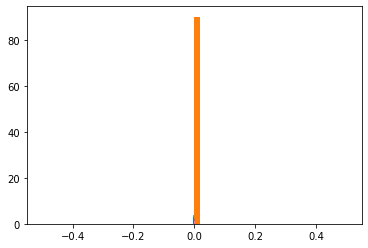

In [8]:
klDiv = get_kldiv("0.out")
print(klDiv)

In [ ]:
#added noise and the values were all different